In [33]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

In [32]:
pd.__version__

'1.4.4'

In [34]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

In [35]:
class ScenarioEnsemble:
    # get the median aggregate scenario ensemble for an individual model given a set of projections for >1 scenario
    # reported in quantile format.
    
    # this method takes the median of all quantiles to find one projection that is an ensemble of all scenarios.
    # performed for all projection locations reported in the given DataFrame
    
    # Input dataframe must have: location, scenario_id, target_end_date, target, value, type, and quantile columns
    
    def __init__(self, df, obsdf, target, incidence = True, max_date = False, start_week = False, end_week = False):
        self.df = df # input dataframe with all scenarios, locations, and quantiles
        self.obsdf = obsdf # input of surveillance data of interest
        self.target = target # target metric of interest (case, death, hospitalization)
        self.inc = incidence # True if incident measures, False if cumulative
        self.max_date = max_date # maximum date you want to analyze, cut off date, in epiweek format
        self.start_week = start_week # beginning of observations of interest, in epiweek format
        self.end_week = end_week # end of observations of interest, in epiweek format
        self.locations = pd.DataFrame()
        self.scenario_ensemble = pd.DataFrame()
        
        
    def get_locations(self):
        # get df with US state names, populations, and abbreviations and corresponding numerical code 
        locations = pd.read_csv('./dat/locations.csv',dtype={'location':str}) 
        
        self.locations = locations
        
        return locations
        
        
    def get_observations(self, target_location):
        # get and format surveillance data of interest for a given target and location 
        observations = self.obsdf.copy()
        
        # formats names
        if self.target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = self.target
            
        # read in observations dataframe
        observations = self.obsdf.copy()
        observations['date'] = pd.to_datetime(observations['date'])

        #filter start - end week for surveillance data
        if self.start_week:
            observations = observations[(observations['date'] >= pd.to_datetime(self.start_week.startdate())) ]
            
        if self.end_week:
            observations = observations[(observations['date'] <= pd.to_datetime(self.end_week.enddate()))]
                                

        #filter location
        observations = observations[observations['location'] == target_location]

        #aggregate to weekly surveillancedata 
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        # cut off observations if there is a maximum date of interest specified
        if self.max_date:
            observations = observations[observations['date'] <= self.max_date].copy()

        #transform to Observation object (reformats dataframe)
        observations = Observations(observations)

        return observations
    

        
    def get_scenarioensemble(self):
        # calculate scenario ensemble for all locations with quantiles reported in the input df
        predictions = self.df
        
        # get all locations you want to find scenario ensemble for
        loclist = list(predictions.location.unique())
        
        
        median_ensembles = pd.DataFrame()
        for l in loclist: # loop through all locations
            
            target_location = l
            
            # transform to datetime object
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            
            # filter for given location
            pred = predictions[predictions['location'] == target_location].copy()
            
            
            # get list of horizon weeks for given target, as specified by COVID-19 SMH data formats
            target_prediction_list = [f"{i} wk ahead {'inc' if self.inc else 'cum'} {self.target}" for \
                                      i in range(1,len(list(pred.target_end_date.unique()))+1)]
                
                
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if self.max_date:
                pred = pred[pred['target_end_date'] <= self.max_date]

            # raise error if there are no predictions for a given model and location, will continue running for 
            # rest of models and locations
            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

                
            ### calculate scenario ensemble ###
            
            
            scenarios = list(pred['scenario_id'].drop_duplicates())
            
            #get list of dataframes for each scenario
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], 
                                            t_col='target_end_date') for scenario in scenarios]
            
            #calculate median scenario ensemble using scorepi package
            med_ensemble_predictions = median_ensemble(predictions_list)
            
            med_ensemble_predictions['location'] = target_location
            med_ensemble_predictions['target'] = self.target
                                               
            median_ensembles = pd.concat([median_ensembles, med_ensemble_predictions])
                                               
            predictions_list += [med_ensemble_predictions]
            labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ["Scenario ensemble"]

        self.scenario_ensemble = median_ensembles
        
        # return concatenated dataframe of scenario ensemble at each location
        return median_ensembles
          

class Scoring(ScenarioEnsemble):
    # calculate score values for probabilistic epidemic forecasts 
    # find WIS, MAPE, and coverage over whole projection window as well as timestamped for every week.
    # uses scorepi package to calculate the scores 
    # score dataframe must have 'Model' column to differentiate and calculate scores for different models
    
    def __init__(self, df, obsdf, scoredf, target, incidence = True, max_date = False, start_week = False, 
                 end_week = False):
        super().__init__(df, obsdf, target, incidence, max_date, start_week, end_week)
        self.scoredf = scoredf #dataframe we want to use to calculate performance analysis/scoring
        
    def get_all_average_scores(self):
        # calculates scores that are averaged over the whole time window
        predictions = self.scoredf.copy()
        
        
        allscore = {}
        for model in predictions.Model.unique():
            allscore[model] = {}
            
            # find scores for each model
            predmod = predictions[predictions.Model==model]
            
            # find scores for each location
            for target_location in predmod.location.unique():
                
                if target_location in ['60','66','69', '72', '78']: #not interested in these locations
                    continue
                
                # get surveillance data
                observations = self.get_observations(target_location)

                pred = predmod[(predmod.location == target_location) ] # filter by location
                pred = Predictions(pred, t_col = 'target_end_date') #reformats predictions dataframe

                # use scorepi function to calculate scores
                d,_ = score_utils.all_scores_from_df(observations, pred, mismatched_allowed=False)

                # output dictionary of scores
                allscore[model][target_location] = d
            
        
        return allscore
    
    def organize_average_scores(self, want_scores):
        # want_scores is list of scores you want to save in the dataframe - could be any scores found in 
        # get_all_average_scores function
        # wis is 'wis_mean', and all coverages are '10_cov', '20_cov', ... '95_cov' etc.
        
        # makes get_all_average_scores output into a pandas dataframe
        average_scores = pd.DataFrame()
        
        allscore = self.get_all_average_scores()
        
        
        for model in allscore.keys():
            scoresmod = allscore[model]
            for loc in scoresmod.keys():
                
                    
                scoresloc = scoresmod[loc]

                scoredict = {'Model': model ,'location': loc}
                for score in want_scores:
                    scoredict[score] = scoresloc[score]


                average_scores = pd.concat([average_scores, pd.DataFrame(scoredict, index=[0])])

        
        average_scores = average_scores.reset_index() 
        average_scores = average_scores.drop(columns=['index'])
        
        return average_scores
    
    
    
    def get_all_timestamped_scores(self):
        # calculates scores for each date of projection (ex. each week) using scorepi package
        predictions = self.scoredf.copy()
        
        allscore = {}
        
        # calculate score for each model
        for model in predictions.Model.unique():
            allscore[model] = {}
            predmod = predictions[predictions.Model==model]
            for target_location in predmod.location.unique(): # filter by location
                if target_location in ['60','66','69', '72', '78']:
                    continue
                    
                observations = self.get_observations(target_location) # get surveillance data

                pred = predmod[(predmod.location == target_location) ]
                pred = Predictions(pred, t_col = 'target_end_date')

                allscore[model][target_location] = {}
                for t in pred.target_end_date.unique(): # calculate score for each projection date
                    prednew = pred[pred.target_end_date == t]
                    obsnew = observations[observations.date == t]

                    # format data
                    obsnew = Observations(obsnew)
                    prednew = Predictions(prednew, t_col = 'target_end_date')

                    # calculate score
                    d = score_utils.all_timestamped_scores_from_df(obsnew, prednew)

                    # store in dictionary
                    allscore[model][target_location][t] = d

        
        return allscore
    
    
    def organize_timestamped_scores(self, want_scores):
        # want_scores is list of scores you want to save in the dataframe, could be any score given as output in
        # get_all_timestamped_scores function
        # wis is 'wis' and all coverages are '10_cov', '20_cov', ... '95_cov' etc.
        
        time_scores = pd.DataFrame()
        
        # makes get_all_timestamped_scores output into a pandas dataframe
        allscore = self.get_all_timestamped_scores()
        
        for model in allscore.keys():
            scoremod = allscore[model]
        
            for loc in scoremod.keys():
                if loc in ['60','66','69', '72', '78']:
                    continue
                    
                scoresloc = scoremod[loc]

                for t in scoresloc.keys():
                    tdf = scoresloc[t]

                    scoredict = {'Model':model ,'location':loc, 'target_end_date':t}
                    for score in want_scores:
                        scoredict[score] = tdf[score]


                    time_scores = pd.concat([time_scores, pd.DataFrame(scoredict, index=[0])])

        
        time_scores = time_scores.reset_index() 
        time_scores = time_scores.drop(columns=['index'])
        
        return time_scores
    
    
    def get_rescaled_wis(self):
        # calculate WIS rescaled by standard deviation 
        # need to have WIS scores for multiple models
        # divide WIS at a given date for each location by the standard deviation of the WIS over all models
        
        #calculate timestamped scores
        time_scores = self.organize_timestamped_scores(['wis'])
        
        time_scores = time_scores[~time_scores['location'].isin(['60','66','69', '72', '78'])]
        
        wisstdev = pd.DataFrame()
        for loc in time_scores.location.unique(): # filter by location
            for date in time_scores.target_end_date.unique(): # filter by date
                df = time_scores[(time_scores.location == loc) & (time_scores.target_end_date == date)]
                
                stdev = df['wis'].std() # calculate standard deviation
                
                # rescale all WIS scores for a given location/date by standard deviation
                df['wis_scaled'] = df['wis'] / stdev 
                
                wisstdev = pd.concat([wisstdev, df]) 
                
        wisstdev = wisstdev.reset_index()
        wisstdev = wisstdev.drop(columns=['index'])
        
        return wisstdev
    
    
    def get_rescaled_wis_observations(self):
        # calculate WIS rescaled by value of observations
        # divide WIS at a given date for each location by the observations at that week/location
        
        aggregated_scores = dict()

        time_scores = self.organize_timestamped_scores(['wis'])
        time_scores = time_scores[~time_scores['location'].isin(['60','66','69', '72', '78'])]

        wisnormdf = pd.DataFrame()
        for model in time_scores.Model.unique():
            for loc in time_scores.location.unique():
                wisdf = time_scores[(time_scores.location == loc) & (time_scores.Model == model)]

                wisvals = list(wisdf.wis)

                observations = self.get_observations(loc) # get surveillance data
                obsvals = list(observations.value)


                wisnorm = []
                for i in range(len(wisvals)):
                    if obsvals[i] == 0:
                        continue
                    else:
                        wisnorm.append(wisvals[i]/obsvals[i])


                wisval = np.mean(wisnorm)

                new_row = pd.DataFrame({'Model': model, 'WISnorm':wisval,'Location': loc}, index=[0])

                wisnormdf = pd.concat([wisnormdf, new_row])
        return wisnormdf

    
    
    
    
    def get_wis_ratios(self, numerator_model, denominator_model, timestamped=False):
        # need all models of interest in score df so we can calculate wis of each
        # input is numerator model and denominator model to calculate wis ratio
        # input whether you want ratio taken at each time point or over average of whole time window 
        
        # calculate ratio of raw WIS, if ratio is close to 1 it indicates that model 
        # performance for both is the same
        
        if timestamped == True: # calculate score at each date
            scores = self.organize_timestamped_scores(['wis'])
        else: # calculate scores averaged over all dates
            scores = self.organize_average_scores(['wis_mean'])
            scores = scores.rename(columns={'wis_mean':'wis'})
        
        num = scores[scores.Model == numerator_model]
        num = num.rename(columns={"wis": "wis_num"})
        
        denom = scores[scores.Model == denominator_model]
        denom = denom.rename(columns={"wis": "wis_denom"})
        
        if timestamped == True:
            scoresmerge = pd.merge(num, denom, how='inner', on = ['location', 'target_end_date'])
        else:
            scoresmerge = pd.merge(num, denom, how='inner', on = ['location'])
            
        # calculate wis ratio 
        scoresmerge['wis_ratio'] = scoresmerge['wis_num'] / scoresmerge['wis_denom']
        
        return scoresmerge
    
    
    def get_mape(self):
        # calculate MAPE as an average over all projections in a given round of scenarios
        predictions = dfall.copy()
        
        # get point forecast, here we say it is the median
        predictions = predictions[predictions['quantile'] == 0.5] # get point forecast, here we say it is the median

        mapedf = pd.DataFrame()

        # find mape for a given model and location over projection period
        for model in predictions.Model.unique():
            predmod = predictions[predictions.Model==model]
            for target_location in predmod.location.unique():

                if target_location in ['60','66','69', '72', '78']:
                    continue

                #test = ScenarioEnsemble(df=df, obsdf=obsdf, target='hosp', incidence = True, max_date = False, 
                #                    start_week = Week(2022,2), end_week = Week(2022, 13))
                observations = self.get_observations(target_location)

                pred = predmod[(predmod.location == target_location) ]
                pred = Predictions(pred, t_col = 'target_end_date')

                n = observations.shape[0]

                mapesum = 0
                realvals = list(observations.value)
                predvals = list(pred.value)

                if len(predvals) == 0:
                    continue

                for i in range(n): # if observation value is 0, ignore it
                    if realvals[i] == 0:
                        n = n - 1
                        continue

                    err = abs((realvals[i]-predvals[i])/realvals[i]) # find relative error

                    mapesum += err

                if n == 0:
                    mape = None
                else:
                    mape = 1/n * mapesum # calculate mape


                data = {'Model': model,'Location': target_location, 'MAPE':mape}

                # store in pandas DataFrame
                newdf = pd.DataFrame(data, index=[1])

                mapedf = pd.concat([mapedf, newdf])

        mapedf = mapedf.reset_index()
        mapedf = mapedf.drop(['index'], axis=1)

        return mapedf
    
        
    
class Plots(Scoring):
    # make plots related to performance analysis, scoring, WIS ratios, etc.
    # uses output from score functions so input must be data you want to be scored and plotted
    
    
    def __init__(self, df, obsdf, scoredf, target, incidence = True, max_date = False, start_week = False, 
                 end_week = False):
        super().__init__(df, obsdf, scoredf, target, incidence, max_date, start_week, end_week)
        
        
    def get_rescaledWIS_boxplot(self):
        # make plot that shows the distribution of rescaled WIS values for all models of interest
        
        df = self.get_rescaled_wis() #calculate rescaled WIS
        
        df = df.rename(columns= {"wis_scaled":"values","Model":"group"})

        wisnormalldf = df
        
        models = list(wisnormalldf.group.unique())
        allmed = []
        for model in models:
            med = wisnormalldf[wisnormalldf['group']== model]['values'].median()
            allmed.append(med)

        a = zip(models, allmed)
        a=list(a)
        res = sorted(a, key = lambda x: x[1])
        modelorder = list(zip(*res))[0]

        # sort models by median value
        wisnormalldf.group = wisnormalldf.group.astype("category")
        wisnormalldf.group = wisnormalldf.group.cat.set_categories(modelorder)
        wisnormalldf.sort_values(["group"])
        
        wisnormalldf = wisnormalldf[wisnormalldf['values'] >= 0] # filter out WIS < 0 (not possible, issue with reported quantiles)
        total_groups = wisnormalldf.group.unique().shape[0]
        total_min = 0 
        
        # plot
        fig, ax = plt.subplots(1,1,figsize = (10,8),tight_layout = False)
        
        i=0
        
        g = sns.boxplot(x='group', y='values', data=wisnormalldf,color = '#17B1BF',showfliers=False)

        for patch in ax.patches:
            r, gr, b, a = patch.get_facecolor()
            patch.set_facecolor((r, gr, b, .1))


        sns.swarmplot(x='group', y='values', data=wisnormalldf,color = "#49AFB7",alpha = .5,size=2, orient="v")    

        plt.ylim([0,np.quantile(wisnormalldf['values'], .95)]) # cuts off some outliers

        g.set(xlabel='')
        g.set(ylabel=r'Rescaled WIS value')

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)


        plt.show()

        
    def get_wisratio_plot(self,numerator_models, denominator_model, timestamped=False):
        # make plots that shows the distribution of WIS ratios for some numerator models all compared to a single
        # reference denominator model.
        
        allratios = pd.DataFrame()
        for model in numerator_models: # calculate wis ratios
            df = self.get_wis_ratios(numerator_model=model, denominator_model=denominator_model,
                                timestamped=timestamped)
            
            allratios = pd.concat([allratios, df])
            
        # plot
        fig = plt.figure(figsize=(7,len(numerator_models)*2.5))
        ax = fig.add_subplot(111)

        my_order = allratios.groupby(by=['Model_x'])['wis_ratio'].median().sort_values(ascending=True).index
        g = sns.boxplot(x='wis_ratio', y='Model_x', data=allratios,order=my_order, color = '#17B1BF',width=.4)

        # plot line at 1 to see where performance for both models is the same
        plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)
        for patch in ax.patches:
            r, gr, b, a = patch.get_facecolor()
            patch.set_facecolor((r, gr, b, .1))

        # plot underlying distribution
        sns.swarmplot(x='wis_ratio', y='Model_x', data=allratios,order=my_order,color = "#49AFB7",alpha = .35,size=3,
                      orient="h")    

        g.set(ylabel=None)
        g.set(yticklabels=[])
        g.set(yticks=[])

        g.set(xlabel='WIS ratio')

        a = 0
        for mod in list(my_order): # write name of all models 
            plt.text(0.01,a-.25, mod, fontsize=10, style='italic', color='dimgray')
            a+=1

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)



        plt.tight_layout()
        plt.show()
        
        
        
    def get_coverage_plot(self):
        # make plot that shows average coverage for a model for different prediction intervals
        
        fig, ax = plt.subplots(1,1,figsize = (8,6),tight_layout = False)
        
        #coverage prediction intervals
        covers = [10,20,30,40,50,60,70,80,90,95,98]
        covsy = [cv/100 for cv in covers]
        
        # get all coverage scores averaged over time window
        df = self.organize_average_scores(want_scores=['10_cov', '20_cov', '30_cov', '40_cov', '50_cov',
                                                      '60_cov', '70_cov', '80_cov', '90_cov', '95_cov', '98_cov'])
        
        
        dfgroup = df.groupby(['Model'], as_index=False).mean()
        
        N = len(dfgroup.Model.unique())
        
        cmap = plt.get_cmap('Set2', N)
        custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
        
        i=0
        for model in dfgroup.Model.unique():
            dfplot = dfgroup[dfgroup.Model == model]
            
            covs = list(dfplot[['10_cov', '20_cov', '30_cov', '40_cov', '50_cov','60_cov', '70_cov', '80_cov', 
                         '90_cov', '95_cov', '98_cov']].values[0])
        
        # plot
            plt.plot(covers, covs, '-o',color=custom_palette[i], label = model)
            
            i += 1
            
        plt.plot(covers, covsy, 'k--',label = 'y = x',linewidth=2) 
        
        plt.xlabel('Prediction Interval', fontsize=14)
        plt.ylabel('Coverage', fontsize=14)

        plt.legend(fontsize=12)
        
        plt.show()


            
    def get_prediction_timeseries_plot(self, target_location):
        
        # make plot of time series envelope at a given location
        
        fontsize=14
        plt.style.use('seaborn-paper')
        plt.rc('text', usetex=True)
        plt.rc('text.latex', preamble=r'\usepackage{lmodern}\usepackage{sfmath}')
        plt.rc('xtick', labelsize=fontsize)
        plt.rc('ytick', labelsize=fontsize)
        plt.rc('axes', labelsize=fontsize)
        color = '#17B1BF'
        
        intervals = [(0.01,0.99),(0.05,0.95),(0.25,0.75)]
        map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
        
        predictions = self.df.copy()
        locations = self.get_locations()
        observations = self.get_observations(target_location)
        
        
        predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
        predictions = predictions.merge(locations, how='inner', on='location')
        
        
        target_prediction_list = [f"{i} wk ahead {'inc' if self.inc else 'cum'} {self.target}" 
                          for i in range(1,len(observations)+1)]
        
        
        #choose location
        pred = predictions[predictions['location'] == target_location].copy()   

        #filter target
        pred = pred[(pred['target'].isin(target_prediction_list))]

        #filter max date
        if self.max_date:
            pred = pred[pred['target_end_date'] <= self.max_date]

        if len(pred) == 0:
            raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

        scenarios = list(pred['scenario_id'].drop_duplicates())

        
        labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] 

        predictions_list = [Predictions(pred[pred['scenario_id'] == scenario],
                             t_col='target_end_date') for scenario in scenarios]

        # make plot
        width = 7
        height = 7
        fig, axes = plt.subplots(2,2, figsize=(width, height), sharey=True)
        
        
        plt.subplots_adjust(left=0.07, bottom=0.08, right=0.99, top=0.85, wspace=0.1,
                            hspace=0.4)
        inds = [[0,0], [0,1], [1,0], [1,1]]
        for ind,(predictions,label) in enumerate(zip(predictions_list,labels)):
            i = inds[ind][0]
            j = inds[ind][1]

            #title
            axes[i][j].set_title(f"{label}", fontsize=fontsize, color='#636363')

            t = np.unique(predictions.get_t())

            #intervals
            for interval in intervals:
                q_low,q_upp = interval
                interval_range = q_upp - q_low
                alpha = map_alpha(interval_range)
                pred_low = predictions.get_quantile(q_low)
                pred_upp = predictions.get_quantile(q_upp)
                axes[i][j].fill_between(t,pred_upp,pred_low, color=color, alpha=alpha,
                                       label=fr"PI {int(round(interval_range*100))} %")
            
            #point estimate
            pred_point = predictions.get_point()
            if len(pred_point) > 0:
                axes[i][j].plot(t,pred_point,'-o',color=color)

            #plot surveillance
            axes[i][j].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a')

            #set x axis
            self.set_date_axis_fmt(axes[i][j])

            #set y axis 
            axes[i][0].set_ylabel(f"Weekly {'incident' if self.inc else 'cumulative'} {self.target}")

        plt.show()

        
    def set_date_axis_fmt(self,ax):
        # plot formatting
        
        # Set the locator
        locator = mdates.MonthLocator()  # every month
        # Specify the format
        fmt = mdates.DateFormatter('%b %y')

        X = ax.xaxis
        X.set_major_locator(locator)
        # Specify formatter
        X.set_major_formatter(fmt)    
        
            
            
    def get_standardized_rank_plot(self):
        # get box plot distribution of standardized rank for a group of models.
        dfrankall = pd.DataFrame()
        
        df = self.organize_average_scores(want_scores=['wis_mean'])
        
        
        dfrank = pd.DataFrame(columns=['Model', 'Location', 'Standard_Rank','Target'])
        
        states = list(df.location.unique())
        
        
        for state in states:
            filt = df[df['location']==state]
            filt = filt.sort_values('wis_mean')

            rank = list(filt.Model)
            for model in rank:
                rankval = 1 - rank.index(model)/(len(rank)-1)

                new_row = {'Model':model, 'Location': state, 'Standard_Rank': rankval, 'Target':target}

                dfrank = dfrank.append(new_row, ignore_index=True)
                
                
        dfrankall = pd.concat([dfrankall, dfrank])
        dfrankallwis = dfrankall.reset_index()
        
        
        my_order = dfrankallwis.groupby(by=["Model"])["Standard_Rank"].median().sort_values(ascending=False).index
    
        g = sns.boxplot(x='Standard_Rank', y='Model', data=dfrankallwis, order = my_order, color = '#17B1BF', width=0.4)

        g.set(yticklabels=[])
        g.set(yticks=[])

        plt.ylabel('', fontsize=15)
        plt.xlabel('Standardized rank', fontsize=15)
        

        a = 0
        for mod in list(my_order):
            plt.text(0,a-.25, mod, fontsize=8, style='italic', color='dimgray')
            a+=1

        plt.xticks(fontsize=13)
        plt.tight_layout()
        plt.show()


        
    def get_vertical_mape_boxplot(self):
        # get vertical boxplot of MAPE distribution compared over models
        
        
        mpl.__version__ # need version 3.5.1 for correct formatting
        
        df = self.get_mape()
        
        df = df.rename(columns={'Model':'group', 'MAPE':'values'})
        
        total_groups = df.group.unique().shape[0]
        total_min = 0 #data['values'].min()*-1.2
        total_max = df['values'].max()*1.2

        fig, ax = plt.subplots(1,total_groups,figsize = (18,18),tight_layout = False)
        plt.subplots_adjust(wspace=-.08)
        i=0
        for group, df1 in df.groupby("group"):
            values = df1["values"].values 
            print(group,np.median(values))

            sns.boxplot(values,ax = ax[i],color = "#49AFB7", showfliers = False, linewidth=1, orient="v")
            for patch in ax[i].patches:
                    r, g, b, a = patch.get_facecolor()
                    patch.set_facecolor((r, g, b, .1))
            sns.swarmplot(values,ax = ax[i],color = "#49AFB7",alpha = .35,size=3, orient="v") 


            #ax[i].axis("off")

            ax[i].tick_params(bottom=False)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["bottom"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].spines["left"].set_visible(False)

           # ax[i].set_ylim(ymin = 0,ymax = 4)
            if i != 0:
                ax[i].set(yticklabels=[])
                ax[i].tick_params(left=False)

            groupnames = group
            text = "%s"
            ax[i].set_xticks([0])
            ax[i].set_xticklabels([groupnames], rotation=40, fontsize=15)

            ax[i].axhline(y = 0,xmin = -5,xmax= 5, color='black')

            i+=1
        ax[0].axis("on")
        #ax[0].set(xticklabels=[])
        ax[0].tick_params(bottom=False)
        ax[0].spines["top"].set_visible(False)
        ax[0].spines["bottom"].set_visible(False)
        ax[0].spines["right"].set_visible(False)
        ax[0].spines["left"].set_visible(True)
        ax[0].set_facecolor("none")
        ax[0].set_ylabel('MAPE value', fontsize=18)
        ax[0].tick_params(axis="y", labelsize=15)

        plt.show()

In [36]:
df = pd.read_parquet(f'./dat/Ensemble_rd12.pq')
df

,scenario_id,scenario_name,target,target_end_date,location,value,type,quantile,model_projection_date
0,A-2022-01-09,optSev_highIE,1 wk ahead cum case,2022-01-15,01,1.041686e+06,quantile,0.01,2022-01-09
1,A-2022-01-09,optSev_highIE,1 wk ahead cum case,2022-01-15,02,1.764332e+05,quantile,0.01,2022-01-09
2,A-2022-01-09,optSev_highIE,1 wk ahead cum case,2022-01-15,04,1.550991e+06,quantile,0.01,2022-01-09
3,A-2022-01-09,optSev_highIE,1 wk ahead cum case,2022-01-15,05,6.631201e+05,quantile,0.01,2022-01-09
4,A-2022-01-09,optSev_highIE,1 wk ahead cum case,2022-01-15,06,6.453597e+06,quantile,0.01,2022-01-09
...,...,...,...,...,...,...,...,...,...
377563,D-2022-01-09,pessSev_lowIE,9 wk ahead inc hosp,2022-03-12,66,0.000000e+00,quantile,0.99,2022-01-09
377564,D-2022-01-09,pessSev_lowIE,9 wk ahead inc hosp,2022-03-12,69,0.000000e+00,quantile,0.99,2022-01-09
377565,D-2022-01-09,pessSev_lowIE,9 wk ahead inc hosp,2022-03-12,72,1.183000e+02,quantile,0.99,2022-01-09
377566,D-2022-01-09,pessSev_lowIE,9 wk ahead inc hosp,2022-03-12,78,5.950000e+01,quantile,0.99,2022-01-09


In [37]:
incidence = True
target_obs = 'hospitalization'
obsdf = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

dfall = pd.DataFrame()
for model in ['Ensemble', 'Ensemble_LOP', "MOBS_NEU-GLEAM_COVID", "JHU_IDD-CovidSP"]:
    df = pd.read_parquet(f'./dat/{model}_rd12.pq')
    test = ScenarioEnsemble(df=df, obsdf=obsdf, target='hosp', incidence = True, max_date = False, 
                            start_week = Week(2022,2), end_week = Week(2022, 13))
    medens = test.get_scenarioensemble()
    medens['Model'] = model

    dfall = pd.concat([dfall, medens])



In [38]:
dfall

,target_end_date,type,quantile,value,location,target,Model
0,2022-01-15,quantile,0.010,812.861394,01,hosp,Ensemble
1,2022-01-15,quantile,0.990,3400.335449,01,hosp,Ensemble
2,2022-01-15,quantile,0.975,3327.432758,01,hosp,Ensemble
3,2022-01-15,quantile,0.950,3244.610454,01,hosp,Ensemble
4,2022-01-15,quantile,0.900,3049.220958,01,hosp,Ensemble
...,...,...,...,...,...,...,...
283,2022-04-02,quantile,0.010,0.000601,56,hosp,JHU_IDD-CovidSP
284,2022-04-02,point,NaN,2.147030,56,hosp,JHU_IDD-CovidSP
285,2022-04-02,quantile,0.975,87.891990,56,hosp,JHU_IDD-CovidSP
286,2022-04-02,quantile,0.400,0.833122,56,hosp,JHU_IDD-CovidSP


In [20]:
test2 = Scoring(df=df, obsdf=obsdf,scoredf = dfall, 
               target='death', incidence = True, max_date = False, 
                        start_week = Week(2022,2), end_week = Week(2022, 13))
d = test2.organize_average_scores(want_scores=['10_cov', '20_cov', '30_cov'])

In [21]:
d

,Model,location,10_cov,20_cov,30_cov
0,Ensemble,01,0.000000,0.000000,0.000000
1,Ensemble,02,0.000000,0.000000,0.083333
2,Ensemble,04,0.000000,0.000000,0.000000
3,Ensemble,05,0.000000,0.000000,0.083333
4,Ensemble,06,0.083333,0.083333,0.083333
...,...,...,...,...,...
213,JHU_IDD-CovidSP,50,0.000000,0.000000,0.083333
214,JHU_IDD-CovidSP,53,0.083333,0.250000,0.333333
215,JHU_IDD-CovidSP,55,0.083333,0.083333,0.166667
216,JHU_IDD-CovidSP,54,0.000000,0.166667,0.250000


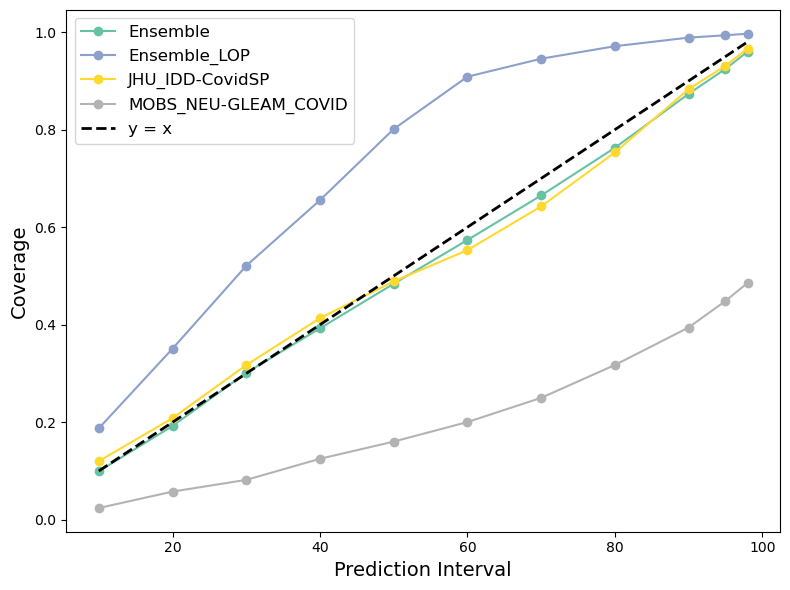

In [96]:
test2 = Plots(df=df, obsdf=obsdf,scoredf = dfall, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = Week(2022,2), end_week = Week(2022, 13))
test2.get_coverage_plot()


In [27]:
test2 = Scoring(df=df, obsdf=obsdf,scoredf = dfall, 
               target='death', incidence = True, max_date = False, 
                        start_week = Week(2022,2), end_week = Week(2022, 13))
d = test2.get_rescaled_wis_observations()

In [30]:
d

,Model,WISnorm,Location
0,Ensemble,0.284887,01
0,Ensemble,0.282444,02
0,Ensemble,0.341615,04
0,Ensemble,0.326199,05
0,Ensemble,0.375455,06
...,...,...,...
0,JHU_IDD-CovidSP,0.266195,53
0,JHU_IDD-CovidSP,0.333846,54
0,JHU_IDD-CovidSP,0.241900,55
0,JHU_IDD-CovidSP,0.251836,56


In [9]:
test2 = Scoring(df=df, obsdf=obsdf,scoredf = dfall, 
               target='death', incidence = True, max_date = False, 
                        start_week = Week(2022,2), end_week = Week(2022, 13))
d = test2.get_mape()

In [10]:
d

,Model,Location,MAPE
0,Ensemble,01,0.485226
1,Ensemble,02,0.390487
2,Ensemble,04,0.519135
3,Ensemble,05,0.543412
4,Ensemble,06,0.538554
...,...,...,...
203,JHU_IDD-CovidSP,50,0.570596
204,JHU_IDD-CovidSP,53,0.436584
205,JHU_IDD-CovidSP,55,0.344420
206,JHU_IDD-CovidSP,54,0.548843


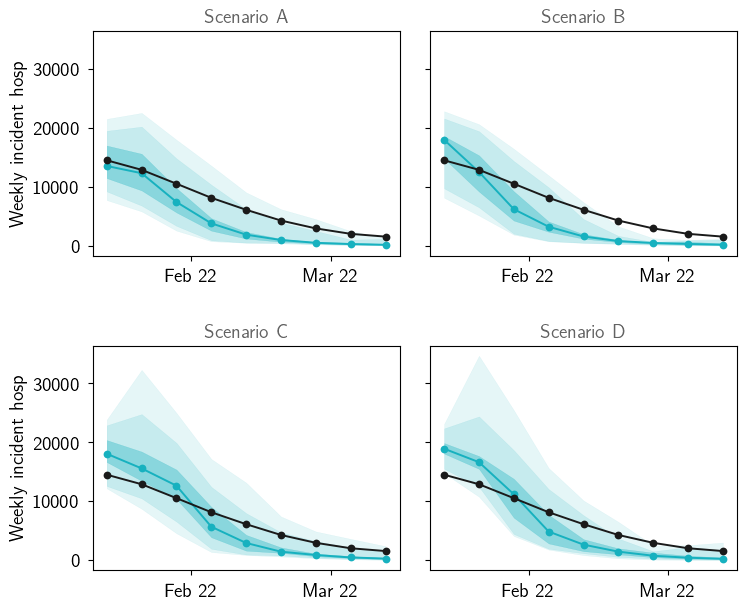

In [40]:
incidence = True
target_obs = 'hospitalization'
obsdf = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

dfall = pd.DataFrame()
df = pd.read_parquet(f'./dat/Ensemble_rd12.pq')
test = Plots(df=df, obsdf=obsdf,scoredf = dfall, 
               target='hosp', incidence = True, max_date = datetime.datetime(2022, 3, 15), 
                        start_week = Week(2022,2), end_week = Week(2022, 13))

test.get_prediction_timeseries_plot(target_location='12')

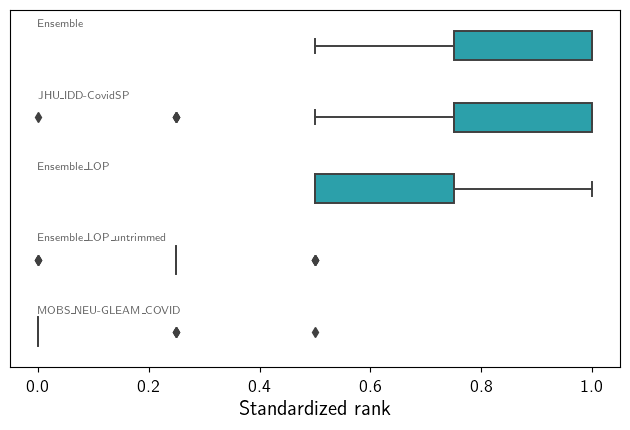

In [73]:
incidence = True
target_obs = 'hospitalization'
obsdf = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

dfall = pd.DataFrame()



for model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed', "MOBS_NEU-GLEAM_COVID", "JHU_IDD-CovidSP"]:
    df = pd.read_parquet(f'./dat/{model}_rd12.pq')
    
    test = Plots(df=df, obsdf=obsdf,scoredf = dfall, 
               target='hosp', incidence = True, max_date = datetime.datetime(2022, 3, 15), 
                        start_week = Week(2022,2), end_week = Week(2022, 13))
    
    scenensemble = test.get_scenarioensemble()
    scenensemble['Model'] = model
    
    dfall = pd.concat([dfall, scenensemble])
    
test2 = Plots(df=dfall, obsdf=obsdf,scoredf = dfall, 
               target='hosp', incidence = True, max_date = datetime.datetime(2022, 3, 15), 
                        start_week = Week(2022,2), end_week = Week(2022, 13))

test2.get_standardized_rank_plot()

Ensemble 0.3798681419294625
Ensemble_LOP 0.3740411865282721
JHU_IDD-CovidSP 0.49111098713349355
MOBS_NEU-GLEAM_COVID 0.8740737624067964


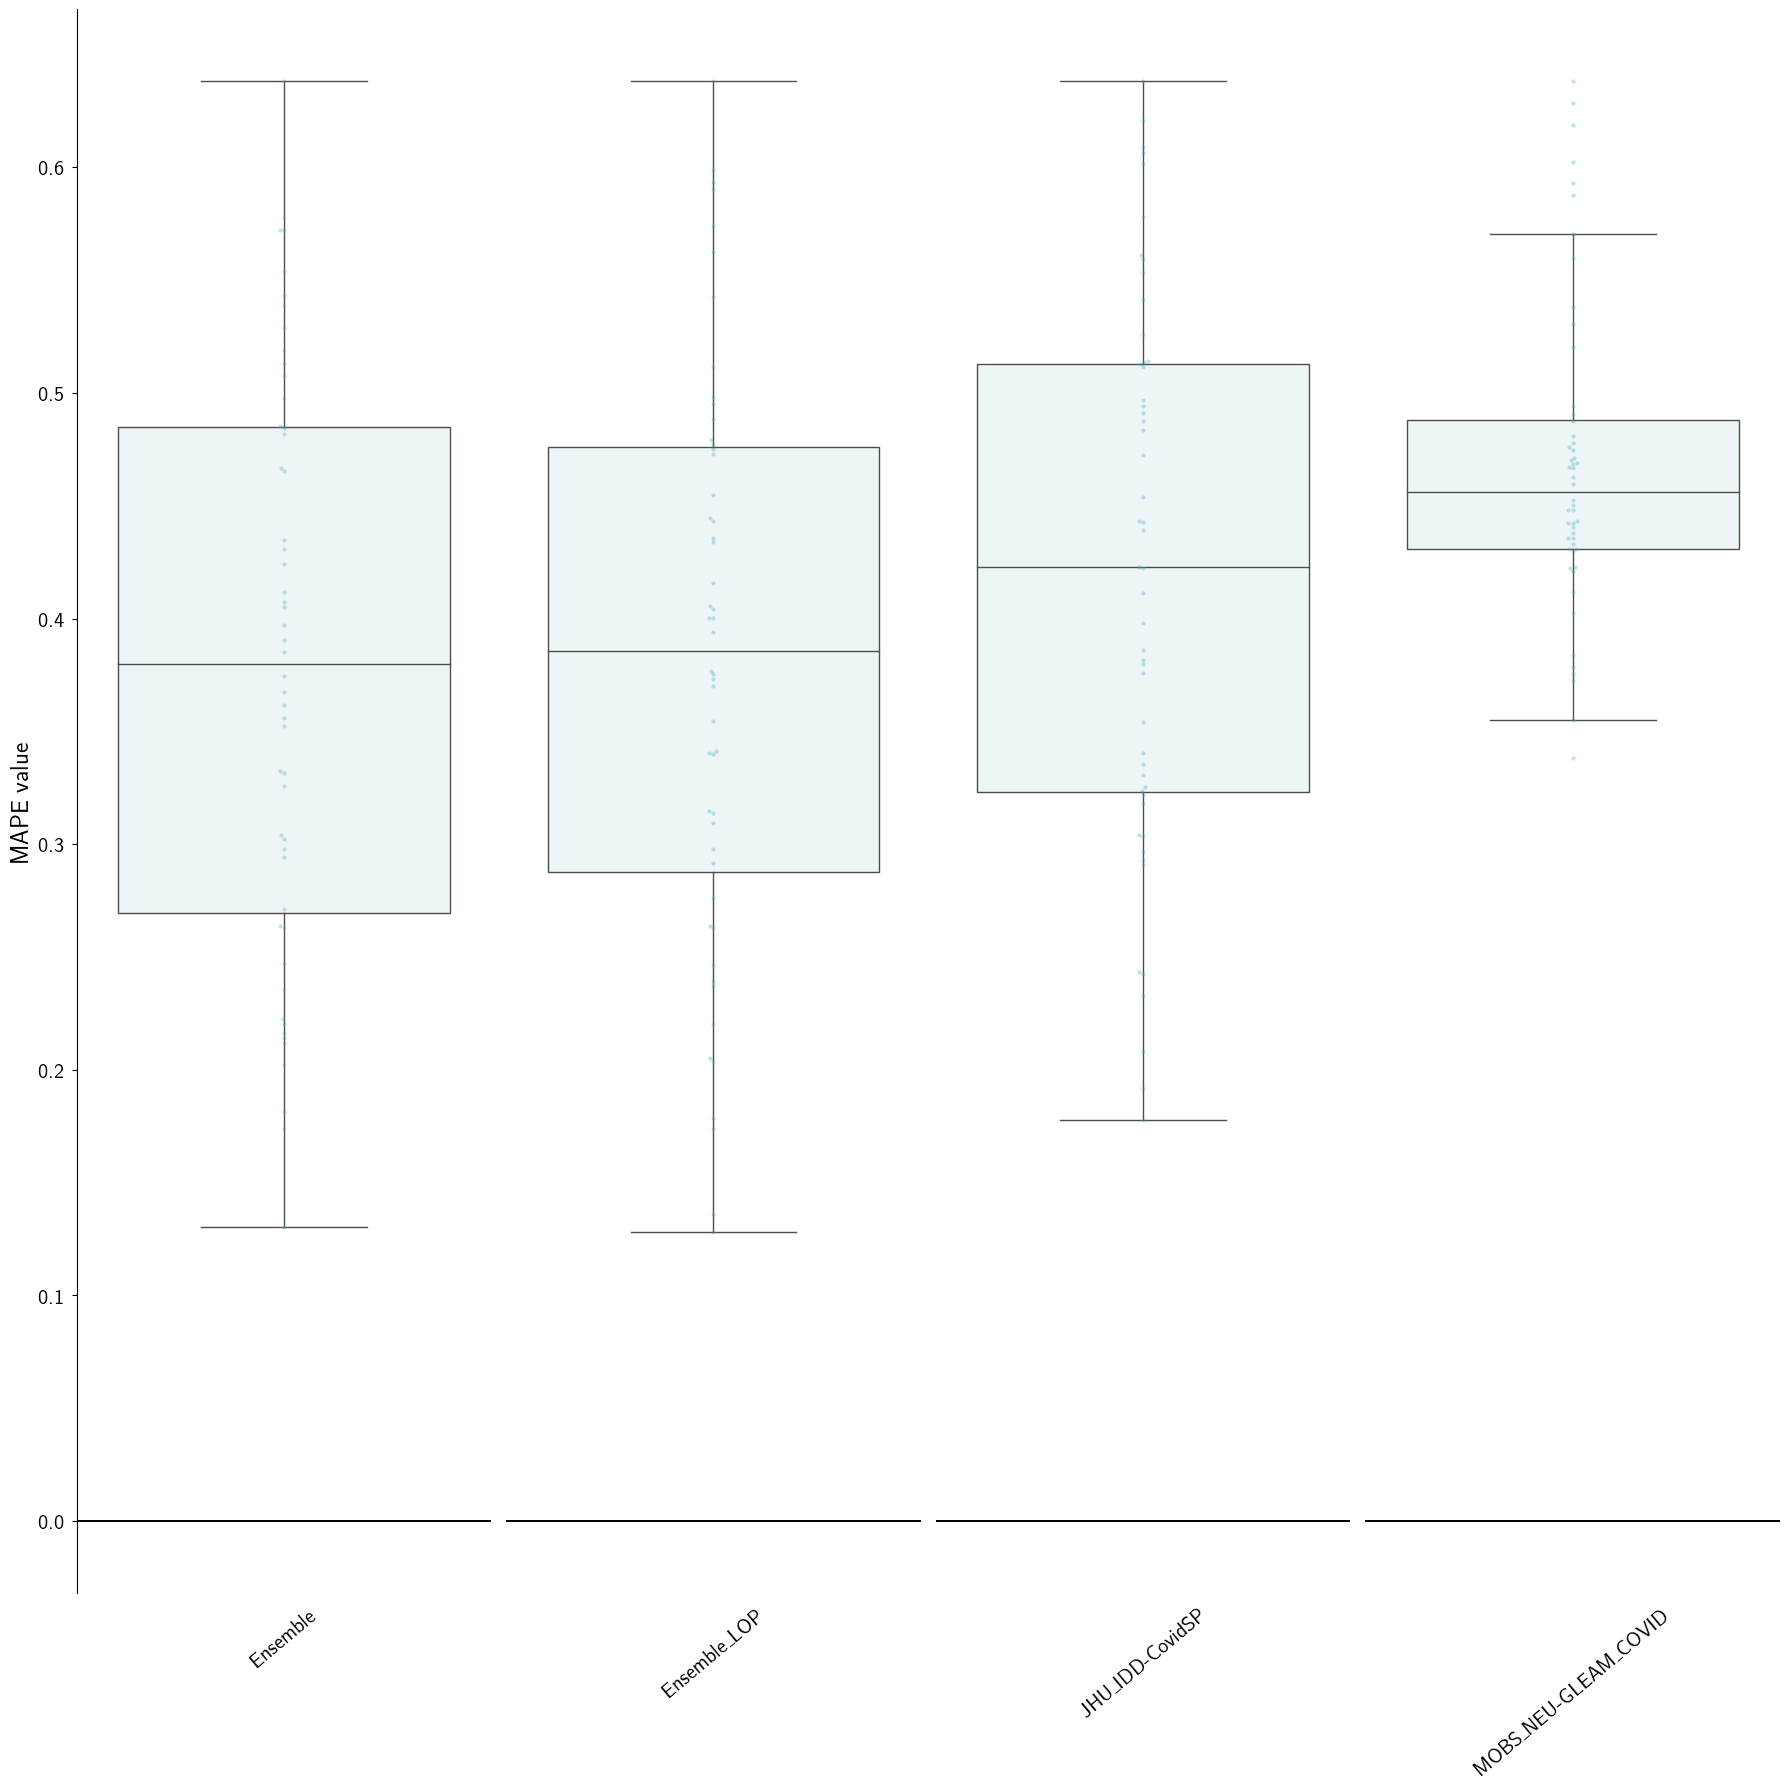

In [100]:

test2 = Plots(df=df, obsdf=obsdf,scoredf = dfall, 
               target='hosp', incidence = True, max_date = False, 
                        start_week = Week(2022,2), end_week = Week(2022, 13))
test2.get_vertical_mape_boxplot()


In [21]:
aggregated_scores = dict()

time_scores = test2.organize_timestamped_scores(['wis'])
time_scores = time_scores[~time_scores['location'].isin(['60','66','69', '72', '78'])]

wisnormdf = pd.DataFrame()
for model in time_scores.Model.unique():
    for loc in time_scores.location.unique():
        wisdf = time_scores[(time_scores.location == loc) & (time_scores.Model == model)]

        wisvals = list(wisdf.wis)

        observations = test2.get_observations(loc) # get surveillance data
        obsvals = list(observations.value)


        wisnorm = []
        for i in range(len(wisvals)):
            if obsvals[i] == 0:
                continue
            else:
                wisnorm.append(wisvals[i]/obsvals[i])


        wisval = np.mean(wisnorm)

        new_row = pd.DataFrame({'Model': model, 'WISnorm':wisval,'Location': loc}, index=[0])

        wisnormdf = pd.concat([wisnormdf, new_row])

,Model,WISnorm,Location
0,Ensemble,0.284887,01
0,Ensemble,0.282444,02
0,Ensemble,0.341615,04
0,Ensemble,0.326199,05
0,Ensemble,0.375455,06
...,...,...,...
0,JHU_IDD-CovidSP,0.266195,53
0,JHU_IDD-CovidSP,0.333846,54
0,JHU_IDD-CovidSP,0.241900,55
0,JHU_IDD-CovidSP,0.251836,56
